# Estimation of recurrence probabilities

### Preparation

In [72]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import statsmodels.tsa.stattools as stattools
from statsmodels.tsa.arima_process import arma_generate_sample
from statsmodels.tsa.arima.model import ARIMA
from datetime import datetime
import pickle
import yaml
config_path = '/home/tu/tu_tu/tu_zxmny46/DS_Project/modules/config.yml'
# config_path = 'C:/Users/stefan/OneDrive - bwedu/04_semester/DS_Project/DS_Project/modules/config.yml'
with open(config_path, 'r') as f:
    config = yaml.load(f, Loader=yaml.FullLoader)

### Data import

In [24]:
dwd = pd.read_csv(config['data']['dwd']+'/dwd.csv')
dwd['MESS_DATUM'] = pd.to_datetime(dwd['MESS_DATUM'], format='%Y-%m-%d %H')
dwd['DATE'] = dwd['MESS_DATUM'].dt.date
years = [2019,2020,2021,2022]
months = [6,7,8]
sub_index = (dwd['STATIONS_ID'] == 3379) & (dwd['MESS_DATUM'].dt.year.isin(years)) & (dwd['MESS_DATUM'].dt.month.isin(months))
tseries = dwd[sub_index].groupby([dwd['DATE']]).max()['TT_TU']
tseries.head()

DATE
2020-06-01    22.3
2020-06-02    23.6
2020-06-03    25.9
2020-06-04    18.6
2020-06-05    16.2
Name: TT_TU, dtype: float64

### Descriptives

In [49]:
y2022_index = pd.to_datetime(tseries.index).to_series().dt.year.isin([2022])

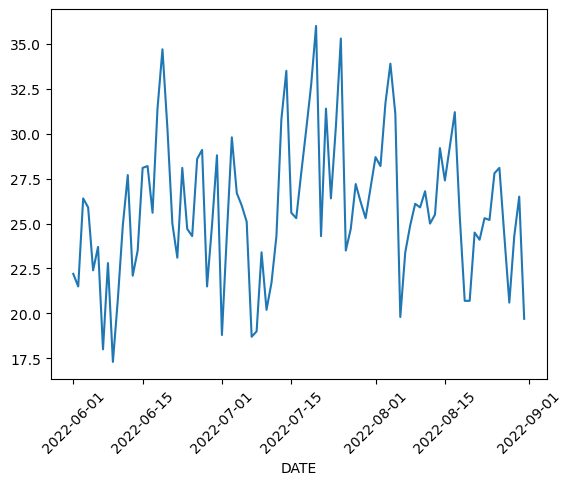

In [50]:
tseries[y2022_index].plot()
plt.xticks(rotation = 45)
plt.show()

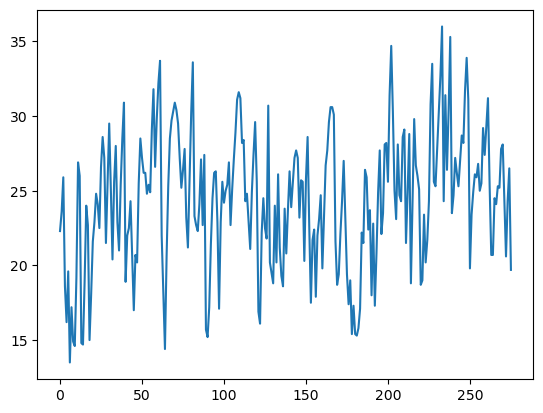

In [25]:
tseries.reset_index(drop=True).plot()
plt.show()

### Modeling ARMA(1)

In [33]:
# dickey fuller test
dickeyfuller = stattools.adfuller(
    tseries,
    autolag="AIC"
)

In [34]:
print('ADF Statistic: %f' % dickeyfuller[0])

print('p-value: %f' % dickeyfuller[1])

print('Critical Values:')

for key, value in dickeyfuller[4].items():
    print('\t%s: %.3f' % (key, value))
if dickeyfuller[0] > dickeyfuller[4]["5%"]:
    print ("Reject Ho - Time Series is Stationary")
else:
    print ("Failed to Reject Ho - Time Series is Stationary")

ADF Statistic: -6.328528
p-value: 0.000000
Critical Values:
	1%: -3.455
	5%: -2.872
	10%: -2.572
Failed to Reject Ho - Time Series is Stationary


In [37]:
arma_mod = ARIMA(tseries.reset_index(drop=True), order=(1,0,1)).fit()

In [38]:
print(arma_mod.summary())

                               SARIMAX Results                                
Dep. Variable:                  TT_TU   No. Observations:                  276
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -743.076
Date:                Mon, 05 Jun 2023   AIC                           1494.151
Time:                        17:11:16   BIC                           1508.633
Sample:                             0   HQIC                          1499.962
                                - 276                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         24.3452      0.547     44.530      0.000      23.274      25.417
ar.L1          0.4809      0.082      5.885      0.000       0.321       0.641
ma.L1          0.1854      0.092      2.010      0.0

### Simulating data

In [58]:
m = tseries.mean()
sd = tseries.std()
standard = (tseries - m) / sd

In [39]:
# extract model parameters
ar = arma_mod.arparams
ma = arma_mod.maparams
ar = np.r_[1, -ar]
ma = np.r_[1, ma]

In [66]:
# simulate data for one year (specified number of months only)
r = 1000000
n = sum(y2022_index)
mat = np.empty([r,n])
for i in range(r):
    mat[i,:] = arma_generate_sample(ar, ma, nsample=n)

In [68]:
# compare to real world data
result = np.empty([r,n])
for i in range(r):
    result[i,:] = np.reshape(np.where(standard[y2022_index] > mat[i,:],1,0),[n,])
means = result.mean(axis=0)

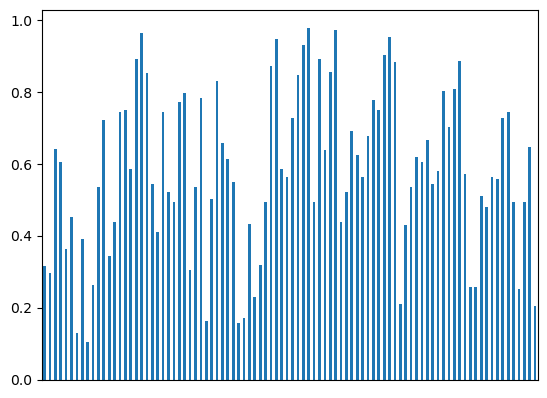

In [69]:
pd.Series(means).plot(kind="bar")
plt.tick_params(
    axis='x',
    which='both',
    bottom=False,
    top=False, 
    labelbottom=False
)
plt.show()

### Compare to identified heatwaves

In [74]:
with open(config['data']['dwd'] + '/heatwaves.pkl', "rb") as input_file:
    heat = pickle.load(input_file)
heat

[datetime.date(2022, 6, 18),
 datetime.date(2022, 6, 19),
 datetime.date(2022, 6, 20),
 datetime.date(2022, 6, 21),
 datetime.date(2022, 7, 18),
 datetime.date(2022, 7, 19),
 datetime.date(2022, 7, 20),
 datetime.date(2022, 8, 3),
 datetime.date(2022, 8, 4),
 datetime.date(2022, 8, 5)]

In [83]:
heat_index = [i in heat for i in pd.to_datetime(tseries[y2022_index].index).to_series().dt.date]
recurrence_prob = pd.Series(means[heat_index], index=heat)

In [85]:
recurrence_prob

2022-06-18    0.893148
2022-06-19    0.966076
2022-06-20    0.852942
2022-06-21    0.543599
2022-07-18    0.848929
2022-07-19    0.930221
2022-07-20    0.980084
2022-08-03    0.903169
2022-08-04    0.954395
2022-08-05    0.883169
dtype: float64